# Part1: Dta pre-processing

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import datetime as dt

from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint, TensorBoard
%matplot inline

UsageError: Line magic function `%matplot` not found.


### Step1: Read Data

In [7]:
dataset_train = pd.read_csv('GOOG.csv')
cols = list(dataset_train)[1:6]

# extract dates will be used in visualization
datelist_train = list(dataset_train['Date'])
datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]

print('Traing set shape == {}'.format(dataset_train.shape))
print('all timestamps == {}'.format(len(datelist_train)))
print('featured selecte: {}'.format(cols))

Traing set shape == (254, 7)
all timestamps == 254
featured selecte: ['Open', 'High', 'Low', 'Close', 'Adj Close']


### Step2: Data pre-processing

In [8]:
dataset_train = dataset_train[cols].astype(str)
for i in cols:
    for j in range(0, len(dataset_train)):
        dataset_train[i][j] = dataset_train[i][j].replace(',','')
dataset_train = dataset_train.astype(float)

training_set = dataset_train.values

print('shape of traing set == {}'.format(training_set.shape))   # 五个特征 --,High,Low,Close,Adj Close,Volume

training_set

shape of traing set == (254, 5)


array([[2276.97998 , 2306.596924, 2266.      , 2296.659912, 2296.659912],
       [2303.      , 2306.439941, 2284.449951, 2297.76001 , 2297.76001 ],
       [2291.97998 , 2318.449951, 2287.844971, 2302.399902, 2302.399902],
       ...,
       [2648.469971, 2648.469971, 2551.52002 , 2567.48999 , 2567.48999 ],
       [2572.530029, 2613.11499 , 2568.771973, 2605.719971, 2605.719971],
       [2612.98999 , 2614.205078, 2542.22998 , 2545.060059, 2545.060059]])

In [9]:
# feature scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:,0:1])  # Open列

array([[-2.20076602],
       [-2.06743785],
       [-2.1239051 ],
       [-2.04238174],
       [-2.15838993],
       [-2.11750003],
       [-2.16751091],
       [-1.98068784],
       [-1.89834383],
       [-1.5337924 ],
       [-1.51747197],
       [-1.54739694],
       [-1.55646662],
       [-1.72545806],
       [-1.73222217],
       [-1.82332813],
       [-1.57040392],
       [-1.69906964],
       [-2.12451934],
       [-2.27901053],
       [-2.2821868 ],
       [-2.12467321],
       [-2.03505343],
       [-1.8937014 ],
       [-2.26522711],
       [-1.93913116],
       [-1.74467329],
       [-1.73949794],
       [-1.4679227 ],
       [-1.5046368 ],
       [-1.38112141],
       [-1.45787974],
       [-1.45767458],
       [-1.38947302],
       [-1.59592164],
       [-1.45500996],
       [-1.30743676],
       [-1.16099194],
       [-1.06055984],
       [-1.08869089],
       [-0.93030661],
       [-0.98938718],
       [-0.90202169],
       [-0.93015274],
       [-1.00440033],
       [-0

In [10]:
# create a data structure with 90 timestampes and  1 output
X_train = []
Y_train = []

n_future = 60 # number of days we want to predict into the future
n_past = 90 # number of days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future + 1):
    X_train.append(training_set_scaled[i - n_past : i, 0 : dataset_train.shape[1] - 1])
    Y_train.append(training_set_scaled[i + n_future - 1: i + n_future, 0])

X_train, Y_train = np.array(X_train), np.array(Y_train)

print('x_train shape == {}'.format(X_train.shape))
print('y_train shape == {}'.format(Y_train.shape))

x_train shape == (105, 90, 4)
y_train shape == (105, 1)


# Part2:Create a model.Training

### Step3:Buliding-up the LSTM based Neural Network

In [11]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
# from keras.optimizers import Adam

In [12]:
model = Sequential()
# add 1st LSTM layer
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, dataset_train.shape[1] - 1)))
# add 2nd LSTM layer
model.add(LSTM(units=10, return_sequences=False))
# add Dropout
model.add(Dropout(0.25))
# Output layer
model.add(Dense(units=1,activation='linear'))
# compiling the Neural Network
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss='mean_squared_error')

### Step4: Start training

In [13]:
es = EarlyStopping(monitor='val_loss',min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1,save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train,Y_train,shuffle=True, epochs=30, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)

Epoch 1/30
1/1 [==============================] - ETA: 0s - loss: 0.7751
Epoch 1: val_loss improved from inf to 0.39384, saving model to weights.h5
1/1 [==============================] - 5s 5s/step - loss: 0.7751 - val_loss: 0.3938 - lr: 0.0100
Epoch 2/30
1/1 [==============================] - ETA: 0s - loss: 0.6362
Epoch 2: val_loss improved from 0.39384 to 0.23911, saving model to weights.h5
1/1 [==============================] - 0s 174ms/step - loss: 0.6362 - val_loss: 0.2391 - lr: 0.0100
Epoch 3/30
1/1 [==============================] - ETA: 0s - loss: 0.5207
Epoch 3: val_loss improved from 0.23911 to 0.19657, saving model to weights.h5
1/1 [==============================] - 0s 199ms/step - loss: 0.5207 - val_loss: 0.1966 - lr: 0.0100
Epoch 4/30
1/1 [==============================] - ETA: 0s - loss: 0.5164
Epoch 4: val_loss did not improve from 0.19657
1/1 [==============================] - 0s 172ms/step - loss: 0.5164 - val_loss: 0.2004 - lr: 0.0100
Epoch 5/30
1/1 [===============

# Part3: Make future prediction

### Step5: Make predictions for future date

In [22]:
# generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future).tolist()

# convert pandas timestamp to datatime objeect  -->  future
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

# perform prediction
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

# inverse the predictions to original measurements
def datetime_to_timestamp(x):
    """
    x : a given datetime value
    """
    return datetime.strptime(x.strftime('%Y%m%d'),'%Y%m%d')

y_pre_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pre_future, columns=['Open']).set_index(pd.Series(datelist_future))
PREDICTIONS_TRAIN = pd.DataFrame(y_pred_train, columns=['Open']).set_index(pd.Series(datelist_train[2 * n_past + n_future - 1 : ]))

# convert <datetime.date> to <timestamp> for PREDICTION_TRAIN
# PREDICTIONS_TRAIN.index = PREDICTIONS_TRAIN.index.to_series().apply(datetime_to_timestamp)

print(PREDICTIONS_FUTURE.head())
PREDICTIONS_TRAIN.head()

                   Open
2022-04-14  2834.471436
2022-04-15  2834.889893
2022-04-16  2828.117188
2022-04-17  2818.269043
2022-04-18  2807.967773


,Open
2022-03-25,2761.388672
2022-03-28,2761.208984
2022-03-29,2761.727051
2022-03-30,2762.612305
2022-03-31,2762.944092


### Step 6: Visiualize the Predicion

In [23]:
# parse training srt timestamp fo better visualization
dataset_train = pd.DataFrame(dataset_train, columns=cols)
dataset_train.index = datelist_train
dataset_train.index = pd.to_datetime(dataset_train.index)

(array([18748., 18809., 18871., 18932., 18993., 19052., 19113., 19174.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

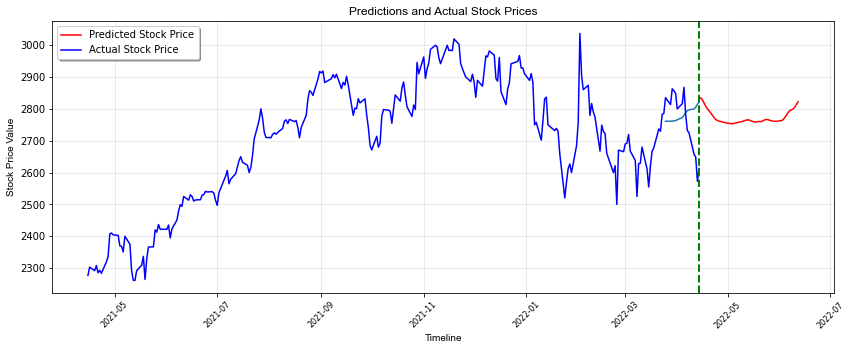

In [32]:
# set plot size
from pylab import rcParams
rcParams['figure.figsize'] = 14,5

# plot parameters
START_DATE_FOR_PLOTTING = '2021-03-25'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Open'], color='r', label='Predicted Stock Price')
# plt.plot(PREDICTIONS_TRAIN['Open'])
# plt.plot(PREDICTIONS_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTIONS_FUTURE.loc[START_DATE_FOR_PLOTTING])

plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING:].index, dataset_train.loc[START_DATE_FOR_PLOTTING:]['Open'], color='b', label='Actual Stock Price')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc',alpha=0.5)

plt.legend(shadow=True)
plt.title('Predictions and Actual Stock Prices', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Stock Price Value', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)